In [1]:
import matplotlib.pyplot as plt
import numpy as np
from pylab import *
from qutip import *
from numpy.linalg import inv

from scipy import optimize
import scipy
from numpy.linalg import inv
# from slab.dsfit import *
import timeit
import numpy.matlib
eq = 1.602/10**19
epsilon = 8.854/10**12
h = 6.636/10**34
hbar = h/2/pi
kb = 1.381/10**23
Tc = 1.2
delta = 1.764*kb*Tc
phi0 = h/2/eq
dielectric = 9.34*epsilon

In [2]:
def chop(expr, delta=10**-9):
    return np.ma.masked_inside(expr,-delta,delta).filled(0)
def fitgeneral(xdata, ydata, fitfunc, fitparams, domain=None, showfit=False, showstartfit=False, showdata=True,
               label="", mark_data='bo', mark_fit='r-'):
    """Uses optimize.leastsq to fit xdata ,ydata using fitfunc and adjusting fit params"""

    # sort data
    order = np.argsort(xdata)
    xdata = xdata[order]
    ydata = ydata[order]

    if domain is not None:
        fitdatax,fitdatay = selectdomain(xdata,ydata,domain)
    else:
        fitdatax=xdata
        fitdatay=ydata
#    print 'minimum', np.min(fitdatay)
#    ymin=np.min(fitdatay)
    errfunc = lambda p, x, y: (fitfunc(p,x) - y) #there shouldn't be **2 # Distance to the target function
    startparams=fitparams # Initial guess for the parameters
    bestfitparams, success = optimize.leastsq(errfunc, startparams[:], args=(fitdatax,fitdatay))
    if showfit:
        if showdata:
            plt.plot(fitdatax,fitdatay,mark_data,label=label+" data")
        if showstartfit:
            plt.plot(fitdatax,fitfunc(startparams,fitdatax),label=label+" startfit")
        plt.plot(fitdatax,fitfunc(bestfitparams,fitdatax),mark_fit,label=label+" fit")
        if label!='': plt.legend()
        err=math.fsum(errfunc(bestfitparams,fitdatax,fitdatay))
        #print 'the best fit has an RMS of {0}'.format(err)
#    plt.t
#    plt.figtext()    
    return bestfitparams

def fitsin(xdata,ydata,fitparams=None,domain=None,showfit=False,showstartfit=False,label=""):
    """Fits sin wave of form: p[0]*np.sin(2.*pi*p[1]*x+p[2]*pi/180.)+p[3]"""
    if domain is not None:
        fitdatax,fitdatay = selectdomain(xdata,ydata,domain)
    else:
        fitdatax=xdata
        fitdatay=ydata
    if fitparams is None:    
        FFT=scipy.fft(fitdatay)
        fft_freqs=scipy.fftpack.fftfreq(len(fitdatay),fitdatax[1]-fitdatax[0])
        max_ind=np.argmax(abs(FFT[4:len(fitdatay)/2.]))+4
        fft_val=FFT[max_ind]
        
        fitparams=[0,0,0,0]
        fitparams[3]=np.mean(fitdatay)
        fitparams[0]=(max(fitdatay)-min(fitdatay))/2.#2*abs(fft_val)/len(fitdatay)
        fitparams[1]=fft_freqs[max_ind]
        fitparams[2]=(cmath.phase(fft_val)-np.pi/2.)*180./np.pi
        #fitparams[3]=(max(fitdatax)-min(fitdatax))
        #fitparams[5]=fitdatax[0]
        
    sin2=lambda p,x: p[0]*np.sin(2.*np.pi*p[1]*x+p[2]*np.pi/180.)+p[3]
    #print "fitparams: ",fitparams
    p1 = fitgeneral(fitdatax, fitdatay, sin2, fitparams, domain=None, showfit=showfit, showstartfit=showstartfit,
                    label=label)
    return p1  

In [3]:
def Vstar_quantization(coupling_param, circuit_param, order=6, output=False):
    #  all parameters in unit GHz
    orderc = 6

    transform = coupling_param['transform']
    diag_energy = coupling_param['diagonal']
#     print(diag_energy)
    
    Ej1 = circuit_param['Ej1']
    Ej2 = circuit_param['Ej2']
    Ejc1 = circuit_param['Ejc1']  
    Ejc2 = circuit_param['Ejc2']
    phidc = circuit_param['phidc']    
    k = coupling_param['k']
    phi2h = coupling_param['phi02/h']
    
    
    Ejs = Ejc1+Ejc2
    d = (Ejc1/Ejc2-1)/(Ejc1/Ejc2+1)
    Ejg = abs(Ejs*sqrt((cos(phidc))**2+d**2*(sin(phidc))**2))
    theta0 = phidc-arctan(d*tan(phidc))
    
    a1 = tensor(destroy(order),qeye(order),qeye(orderc))
    a2 = tensor(qeye(order),destroy(order),qeye(orderc))
    ag = tensor(qeye(order),qeye(order),destroy(orderc)) 
    
    n1 = 1j/sqrt(2)*sqrt((diag_energy[0]))*(a1.dag()-a1)
    n2 = 1j/sqrt(2)*sqrt((diag_energy[1]))*(a2.dag()-a2)
    ng = 1j/sqrt(2)*sqrt((diag_energy[2]))*(ag.dag()-ag)
    
    p1 = 1/sqrt(2)/sqrt((diag_energy[0]))*(a1.dag()+a1)
    p2 = 1/sqrt(2)/sqrt((diag_energy[1]))*(a2.dag()+a2)
    pg = 1/sqrt(2)/sqrt((diag_energy[2]))*(ag.dag()+ag)
    
    p1_t = (transform[0,0]*p1+transform[0,1]*p2+transform[0,2]*pg)
    p2_t = (transform[1,0]*p1+transform[1,1]*p2+transform[1,2]*pg)
    pg_t = (transform[2,0]*p1+transform[2,1]*p2+transform[2,2]*pg)
    
    n1_t = (transform[0,0]*n1+transform[0,1]*n2+transform[0,2]*ng)
    n2_t = (transform[1,0]*n1+transform[1,1]*n2+transform[1,2]*ng)
    ng_t = (transform[2,0]*n1+transform[2,1]*n2+transform[2,2]*ng)

    H = -Ej1*(p1_t-pg_t).cosm()-Ej2*(p2_t-pg_t).cosm()-Ejg*pg_t.cosm()+(n1**2+n2**2+ng**2)/2*phi2h

    
    
    result = H.eigenstates()
    energy = result[0]
    state = result[1]
    
    
    #  reordering the eigenvalues
    max_list = []
    maxlist = np.zeros([order,order,orderc])
    for i in range(len(state)):
        aaa = abs(np.array(state[i]))
        name = np.argmax(aaa)
        k1 = name // (order*orderc)
        k2 = (name - k1 * (order*orderc))//orderc
        k3 = name-k1 * (order*orderc)-k2*orderc
        now = state[i].dag()*H*state[i]
        maxlist[k1][k2][k3] = np.array(now)[0][0]
    maxlist = maxlist-energy[0]
    maxlist = maxlist
        
    # calculate all information
    Q1 = maxlist[1][0][0] - maxlist[0][0][0]
    Q2 = maxlist[0][1][0] - maxlist[0][0][0]
    Qc = maxlist[0][0][1] - maxlist[0][0][0]
    ZZ = maxlist[1][1][0] - maxlist[1][0][0] - maxlist[0][1][0] + maxlist[0][0][0]
    ZZef = maxlist[1][2][0] - maxlist[1][0][0] - maxlist[0][2][0] + maxlist[0][0][0]
    ZZfe = maxlist[2][1][0] - maxlist[2][0][0] - maxlist[0][1][0] + maxlist[0][0][0]
    Q1_a = maxlist[2][0][0] - 2*maxlist[1][0][0] + maxlist[0][0][0]
    Q2_a = maxlist[0][2][0] - 2*maxlist[0][1][0] + maxlist[0][0][0]
    Q3_a = maxlist[0][0][2] - 2*maxlist[0][0][1] + maxlist[0][0][0]
    ZZ_1g = maxlist[1][0][1] - maxlist[1][0][0] - maxlist[0][0][1] + maxlist[0][0][0]
    ZZ_2g = maxlist[0][1][1] - maxlist[0][1][0] - maxlist[0][0][1] + maxlist[0][0][0]
    ZZ_gf = maxlist[2][2][0] - maxlist[2][0][0] - maxlist[0][2][0] + maxlist[0][0][0]
    
    if output:
        print('Q1: ',Q1)
        print('Q2: ',Q2)
        print('Qc: ',Qc)
        print('ZZ: ',ZZ)
        print('ZZef: ',ZZef)
        print('ZZfe: ',ZZfe)
        print('ZZgf: ',ZZ_gf)
        print('ZZ1g: ',ZZ_1g)
        print('ZZ2g: ',ZZ_2g)
        print('Q1_a: ',Q1_a)
        print('Q2_a: ',Q2_a)
        print('Q3_a: ',Q3_a)
    
    return maxlist

# single DC flux point

In [4]:
start = timeit.default_timer()
order = 12
Phidc = 0.43 * pi

###########################################################
# factor of simulation and room temperature measurement
HFSSratio = 1.0
Rratio = 1.04
##########################################################
# simulation results
CQ1 = 120.71/10**15*HFSSratio
CQ2 = 78.44/10**15*HFSSratio*0.99
CQ12 = 3.255/10**15*HFSSratio

###########################################################
# room temperature measurement results
Rj1 = 14349 * Rratio * 1.0085
Rj2 = 13051 * Rratio * 1.0085
Rjc1 = 227 * Rratio
Rjc2 = 220 * Rratio
##########################################################
# 'Experience' constant
thickness = 1.4/10**9
# resistance vs. capacitance
r_standard = 16000
width = 165/10**9
length = 155/10**9
Cj1 = (dielectric*length*width)/thickness*r_standard/Rj1*Rratio
Cj2 = (dielectric*length*width)/thickness*r_standard/Rj2*Rratio
# Cj1=5*10**(-15)
# Cj2=5*10**(-15)
Cjc1 = (dielectric*length*width)/thickness*r_standard/Rjc1
Cjc2 = (dielectric*length*width)/thickness*r_standard/Rjc2
Cg = Cjc1 + Cjc2
##########################################################
Ej1 = h/8*delta/eq**2/Rj1
Ej2 = h/8*delta/eq**2/Rj2
Ejc1 = h/8*delta/eq**2/Rjc1
Ejc2 = h/8*delta/eq**2/Rjc2
# capacitive energy matrix
CL = np.matrix([[CQ1+CQ12+Cj1, -CQ12,        -Cj1      ],
                [-CQ12,        CQ2+CQ12+Cj2, -Cj2      ],
                [-Cj1,         -Cj2,         Cg+Cj1+Cj2]])
CL = CL*10**15
# CL = np.matrix([[107.86, -5.55, -1.6],[-5.55,67.97,-1.76],[-1.6,-1.76,211.38]])

Ejs = Ejc1+Ejc2
d = (Ejc1-Ejc2)/(Ejc1+Ejc2)
Ejg = abs(Ejs*sqrt(cos(Phidc)**2+d**2*sin(Phidc)**2))
theta0 = Phidc-arctan(d*tan(Phidc))

Lj1=hbar*Rj1/pi/delta*10**9
Lj2=hbar*Rj2/pi/delta*10**9
Ljc1=hbar*Rjc1/pi/delta*10**9
Ljc2=hbar*Rjc2/pi/delta*10**9
Lg=hbar*hbar/4/eq/eq/Ejg*10**9
# inductive matrix
Linductive = np.matrix([[1/Lj1, 0,      -1/Lj1          ],
                        [0,     1/Lj2,  -1/Lj2          ],
                        [-1/Lj1, -1/Lj2, 1/Lg+1/Lj1+1/Lj2]])
Linductive = Linductive

# simultaneous diagonalization
eigvals, eigvecs = np.linalg.eig(CL)
eigvecs1 = eigvecs
for i in range(size(CL[0])):
    eigvecs1[:,i]=eigvecs[:,i]/sqrt(eigvals[i])
eigvals2, eigvecs2 = np.linalg.eig(np.dot(np.dot(transpose(eigvecs1), Linductive), eigvecs1))
transform = np.dot(eigvecs1,eigvecs2)
# New mode=Transform^-1*Mode(Q1,Q2,Qc)


##################################################
eig_list = sqrt(eigvals2)
# sort according to values
label=np.argsort(abs(eig_list))
transform_new = np.matlib.zeros([len(eig_list),len(eig_list)])
for ii in range(len(eig_list)):
    for jj in range(len(eig_list)):
        transform_new[ii,jj] = transform[ii,label[jj]]
    
coupling_param = {}
coupling_param['transform'] = chop(transform_new)
coupling_param['diagonal'] = np.sort(eig_list)
coupling_param['C'] = CL/10**15
coupling_param['L'] = Linductive*10**9
coupling_param['k'] = 2*pi/phi0*sqrt(hbar/2*1e3)
coupling_param['phi02/h'] = phi0**2/h/4/pi/pi

circuit_param = {}
circuit_param['Ej1'] = Ej1/h/10**9
circuit_param['Ej2'] = Ej2/h/10**9
circuit_param['Ejc1'] = Ejc1/h/10**9
circuit_param['Ejc2'] = Ejc2/h/10**9
circuit_param['phidc'] = Phidc

results = Vstar_quantization(coupling_param, circuit_param, order=order, output=True)
freq_list = []
freq_list.append(0) # gg
freq_list.append(results[0][1][0]-results[0][0][0]) # ge
freq_list.append(results[0][2][0]-results[0][0][0]) # gf
freq_list.append(results[0][3][0]-results[0][0][0]) # gh

freq_list.append(results[1][0][0]-results[0][0][0]) # eg
freq_list.append(results[1][1][0]-results[0][0][0]) # ee
freq_list.append(results[1][2][0]-results[0][0][0]) # ef
freq_list.append(results[1][3][0]-results[0][0][0]) # eh

freq_list.append(results[2][0][0]-results[0][0][0]) # fg
freq_list.append(results[2][1][0]-results[0][0][0]) # fe
freq_list.append(results[2][2][0]-results[0][0][0]) # ff
freq_list.append(results[2][3][0]-results[0][0][0]) # fh

freq_list.append(results[3][0][0]-results[0][0][0]) # hg
freq_list.append(results[3][1][0]-results[0][0][0]) # he
freq_list.append(results[3][2][0]-results[0][0][0]) # hf
freq_list.append(results[3][3][0]-results[0][0][0]) # hh
stop = timeit.default_timer()

print('Time: ', stop - start)
print(freq_list)



C:\Users\slab\.conda\envs\Vstar\lib\site-packages\ipykernel_launcher.py:62: ComplexWarning: Casting complex values to real discards the imaginary part


Q1:  3.2711440188052734
Q2:  4.181231172000878
Qc:  14.796627504580954
ZZ:  -0.00035221557180875607
ZZef:  -0.0007951961232492977
ZZfe:  -0.0006899253807546302
ZZgf:  -0.001514674479437872
ZZ1g:  -0.04764090724501102
ZZ2g:  -0.0633824069586808
Q1_a:  -0.16914084059760626
Q2_a:  -0.2619629862905981
Q3_a:  -0.09730108706563101
Time:  5.2627251
[0, 4.181231172000878, 8.100499357711158, 11.705075793025514, 3.2711440188052734, 7.4520229752343425, 11.370848180393182, 14.991238093870493, 6.3731471970129405, 10.553688443633064, 14.47213188024466, 18.070551440365875, 9.282183721584943, 13.462414551114534, 17.38061434699, 20.981001508654145]


In [51]:
# sweep range
sweep_range = np.linspace(-0.0, 0.49, 101) * pi
fQ1 = []
fQ2 = []
fQc = []
ZZ = []
ZZef = []
ZZfe = []
ZZgf = []
ZZ1g = []
ZZ2g = []
Q1_a = []
Q2_a = []
iterno = 0
for Phidc in sweep_range:
    ##########################################################
    if iterno%10==0:
        print('Step number: ',iterno)
    iterno+=1
    Ej1 = h/8*delta/eq**2/Rj1
    Ej2 = h/8*delta/eq**2/Rj2
    Ejc1 = h/8*delta/eq**2/Rjc1
    Ejc2 = h/8*delta/eq**2/Rjc2
    # capacitive energy matrix
    CL = np.matrix([[CQ1+CQ12+Cj1, -CQ12,        -Cj1      ],
                    [-CQ12,        CQ2+CQ12+Cj2, -Cj2      ],
                    [-Cj1,         -Cj2,         Cg+Cj1+Cj2]])
    CL = CL*10**15
    # CL = np.matrix([[107.86, -5.55, -1.6],[-5.55,67.97,-1.76],[-1.6,-1.76,211.38]])

    Ejs = Ejc1+Ejc2
    d = (Ejc1-Ejc2)/(Ejc1+Ejc2)
    Ejg = abs(Ejs*sqrt(cos(Phidc)**2+d**2*sin(Phidc)**2))
    theta0 = Phidc-arctan(d*tan(Phidc))

    Lj1=hbar*Rj1/pi/delta*10**9
    Lj2=hbar*Rj2/pi/delta*10**9
    Ljc1=hbar*Rjc1/pi/delta*10**9
    Ljc2=hbar*Rjc2/pi/delta*10**9
    Lg=hbar*hbar/4/eq/eq/Ejg*10**9
    # inductive matrix
    Linductive = np.matrix([[1/Lj1, 0,      -1/Lj1          ],
                            [0,     1/Lj2,  -1/Lj2          ],
                            [-1/Lj1, -1/Lj2, 1/Lg+1/Lj1+1/Lj2]])
    Linductive = Linductive

    # simultaneous diagonalization
    eigvals, eigvecs = np.linalg.eig(CL)
    eigvecs1 = eigvecs
    for i in range(size(CL[0])):
        eigvecs1[:,i]=eigvecs[:,i]/sqrt(eigvals[i])
    eigvals2, eigvecs2 = np.linalg.eig(np.dot(np.dot(transpose(eigvecs1), Linductive), eigvecs1))
    transform = np.dot(eigvecs1,eigvecs2)
    # New mode=Transform^-1*Mode(Q1,Q2,Qc)


    ##################################################
    eig_list = sqrt(eigvals2)
    # sort according to values
    label=np.argsort(abs(eig_list))
    transform_new = np.matlib.zeros([len(eig_list),len(eig_list)])
    for ii in range(len(eig_list)):
        for jj in range(len(eig_list)):
            transform_new[ii,jj] = transform[ii,label[jj]]

    coupling_param = {}
    coupling_param['transform'] = chop(transform_new)
    coupling_param['diagonal'] = np.sort(eig_list)
    coupling_param['C'] = CL/10**15
    coupling_param['L'] = Linductive*10**9
    coupling_param['k'] = 2*pi/phi0*sqrt(hbar/2*1e3)
    coupling_param['phi02/h'] = phi0**2/h/4/pi/pi

    circuit_param = {}
    circuit_param['Ej1'] = Ej1/h/10**9
    circuit_param['Ej2'] = Ej2/h/10**9
    circuit_param['Ejc1'] = Ejc1/h/10**9
    circuit_param['Ejc2'] = Ejc2/h/10**9
    circuit_param['phidc'] = Phidc

    results = Vstar_quantization(coupling_param, circuit_param, order=order, output=False)
    
    fQ1.append(results[1][0][0]-results[0][0][0])
    fQ2.append(results[0][1][0]-results[0][0][0])
    fQc.append(results[0][0][1]-results[0][0][0])
    ZZ.append(results[1][1][0]+results[0][0][0]-results[1][0][0]-results[0][1][0])
    ZZef.append(results[1][2][0]+results[0][0][0]-results[1][0][0]-results[0][2][0])
    ZZfe.append(results[2][1][0]+results[0][0][0]-results[2][0][0]-results[0][1][0])
    ZZ1g.append(results[1][0][1]+results[0][0][0]-results[1][0][0]-results[0][0][1])
    ZZ2g.append(results[0][1][1]+results[0][0][0]-results[0][1][0]-results[0][0][1])
    ZZgf.append(results[2][2][0]+results[0][0][0]-results[2][0][0]-results[0][2][0])
    Q1_a.append(results[2][0][0]-2*results[1][0][0]+results[0][0][0])
    Q2_a.append(results[0][2][0]-2*results[0][1][0]+results[0][0][0])
    


Step number:  0


C:\Users\slab\.conda\envs\Vstar\lib\site-packages\ipykernel_launcher.py:62: ComplexWarning: Casting complex values to real discards the imaginary part


Step number:  10
Step number:  20
Step number:  30
Step number:  40
Step number:  50
Step number:  60
Step number:  70
Step number:  80
Step number:  90
Step number:  100


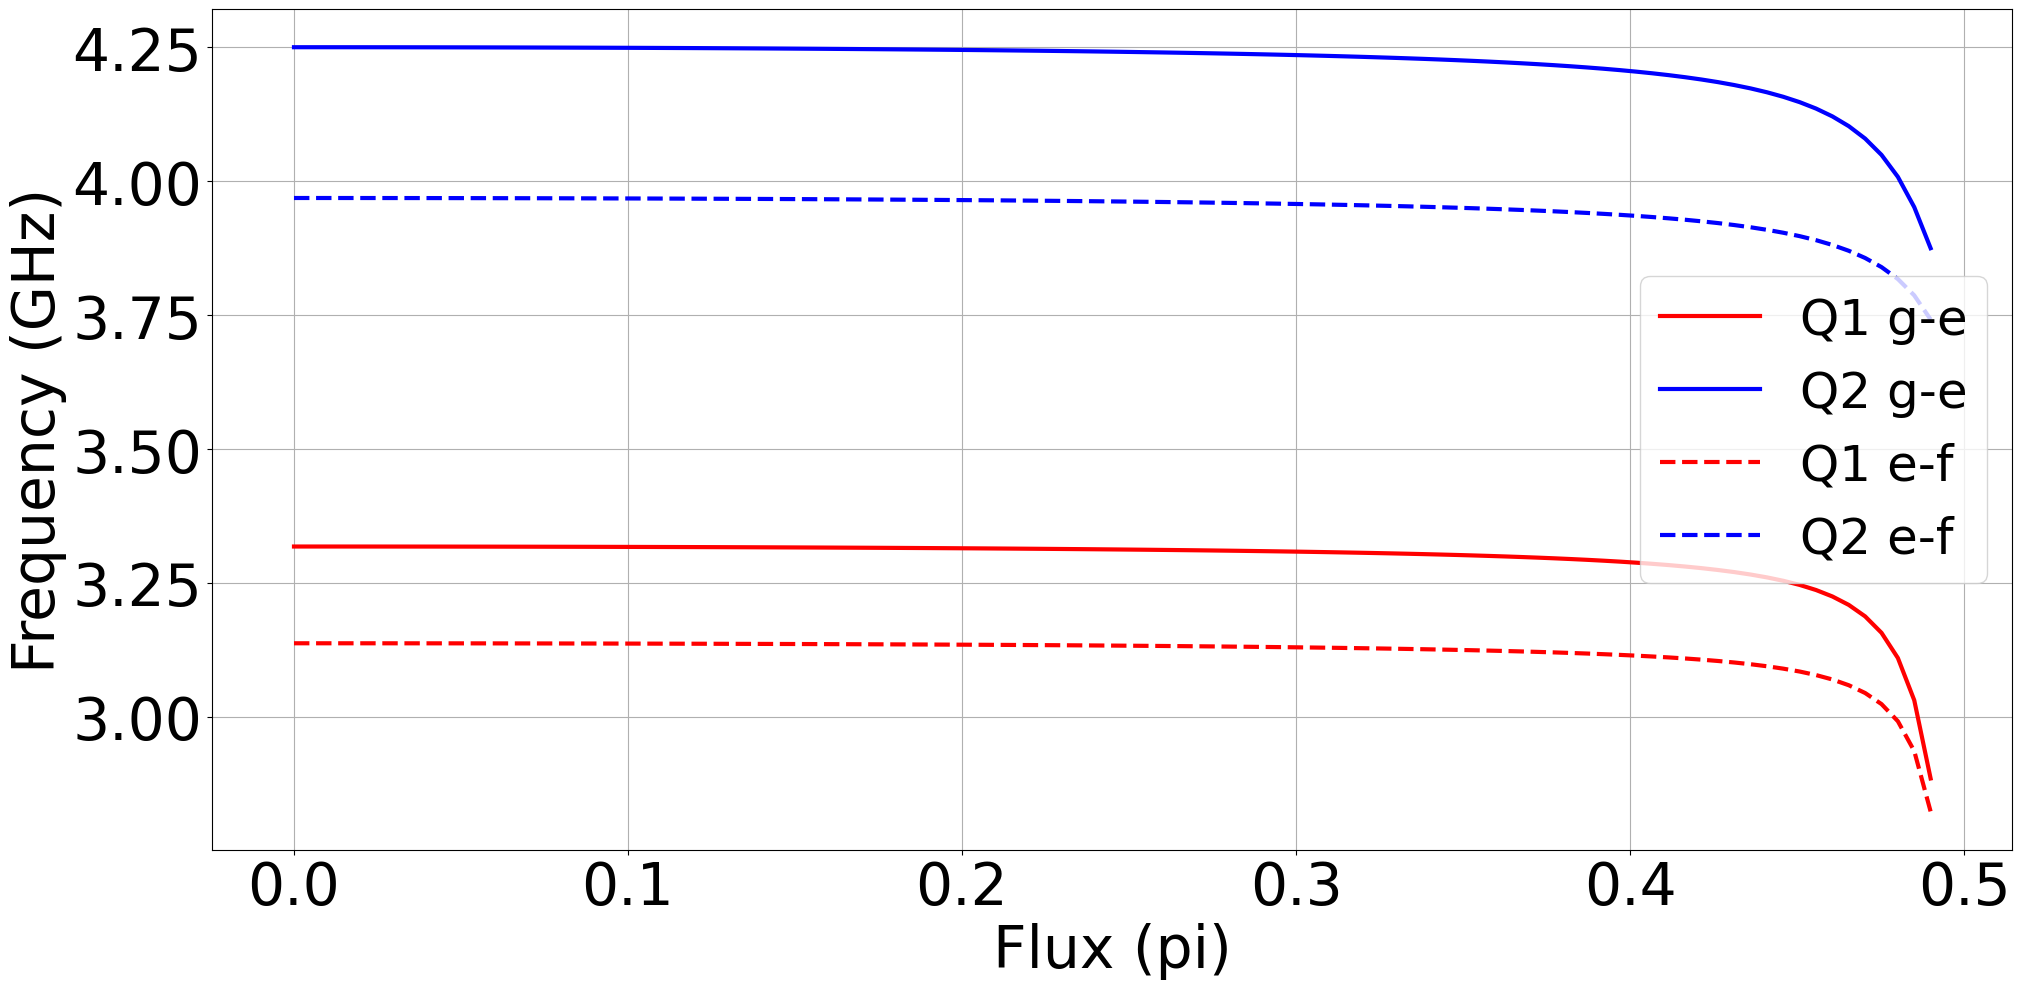

In [52]:
fig1 = plt.figure(figsize=(20,10))
plt.plot(sweep_range/pi,fQ1, color='red', linewidth=3, linestyle='-', marker='o',markersize=0.,label=r'Q1 g-e')
plt.plot(sweep_range/pi,fQ2, color='blue', linewidth=3, linestyle='-', marker='o',markersize=0.,label=r'Q2 g-e')
plt.plot(sweep_range/pi,[sum(x) for x in zip(fQ1, Q1_a)], color='red', linewidth=3, linestyle='--', marker='o',markersize=0.,label=r'Q1 e-f')
plt.plot(sweep_range/pi,[sum(x) for x in zip(fQ2, Q2_a)], color='blue', linewidth=3, linestyle='--', marker='o',markersize=0.,label=r'Q2 e-f')

plt.tick_params(labelsize=42)
plt.rcParams['xtick.direction'] = 'in'  
plt.rcParams['ytick.direction'] = 'in'
# plt.title('Theoretical Fidelity', fontsize=36)
plt.xlabel('Flux (pi)', fontsize=42)
plt.ylabel('Frequency (GHz)', fontsize=42)
plt.legend(fontsize=36)
plt.grid()
plt.tight_layout()
plt.show()


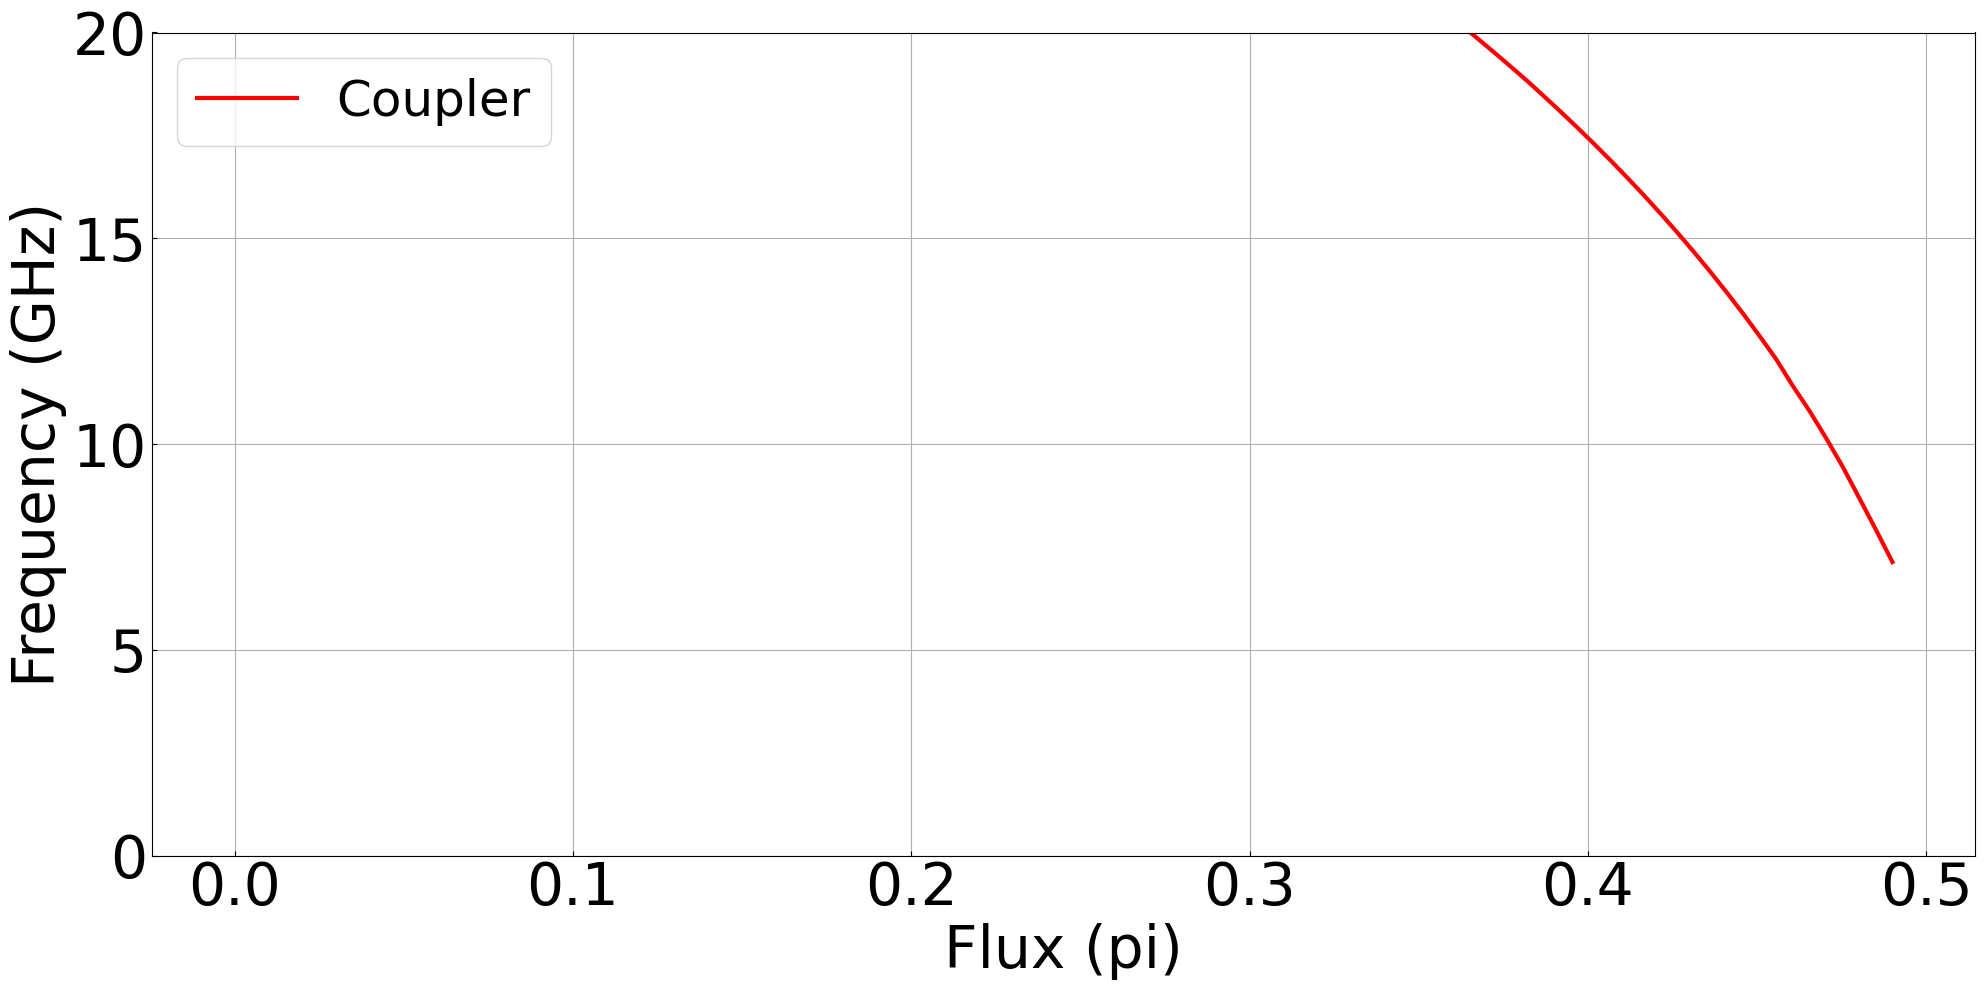

In [53]:
fig1 = plt.figure(figsize=(20,10))
plt.plot(sweep_range/pi,fQc, color='red', linewidth=3, linestyle='-', marker='o',markersize=0.,label=r'Coupler')

plt.tick_params(labelsize=42)
plt.rcParams['xtick.direction'] = 'in'  
plt.rcParams['ytick.direction'] = 'in'
# plt.title('Theoretical Fidelity', fontsize=36)
plt.xlabel('Flux (pi)', fontsize=42)
plt.ylabel('Frequency (GHz)', fontsize=42)
plt.ylim(0, 20)
plt.legend(fontsize=36)
plt.grid()
plt.tight_layout()
plt.show()

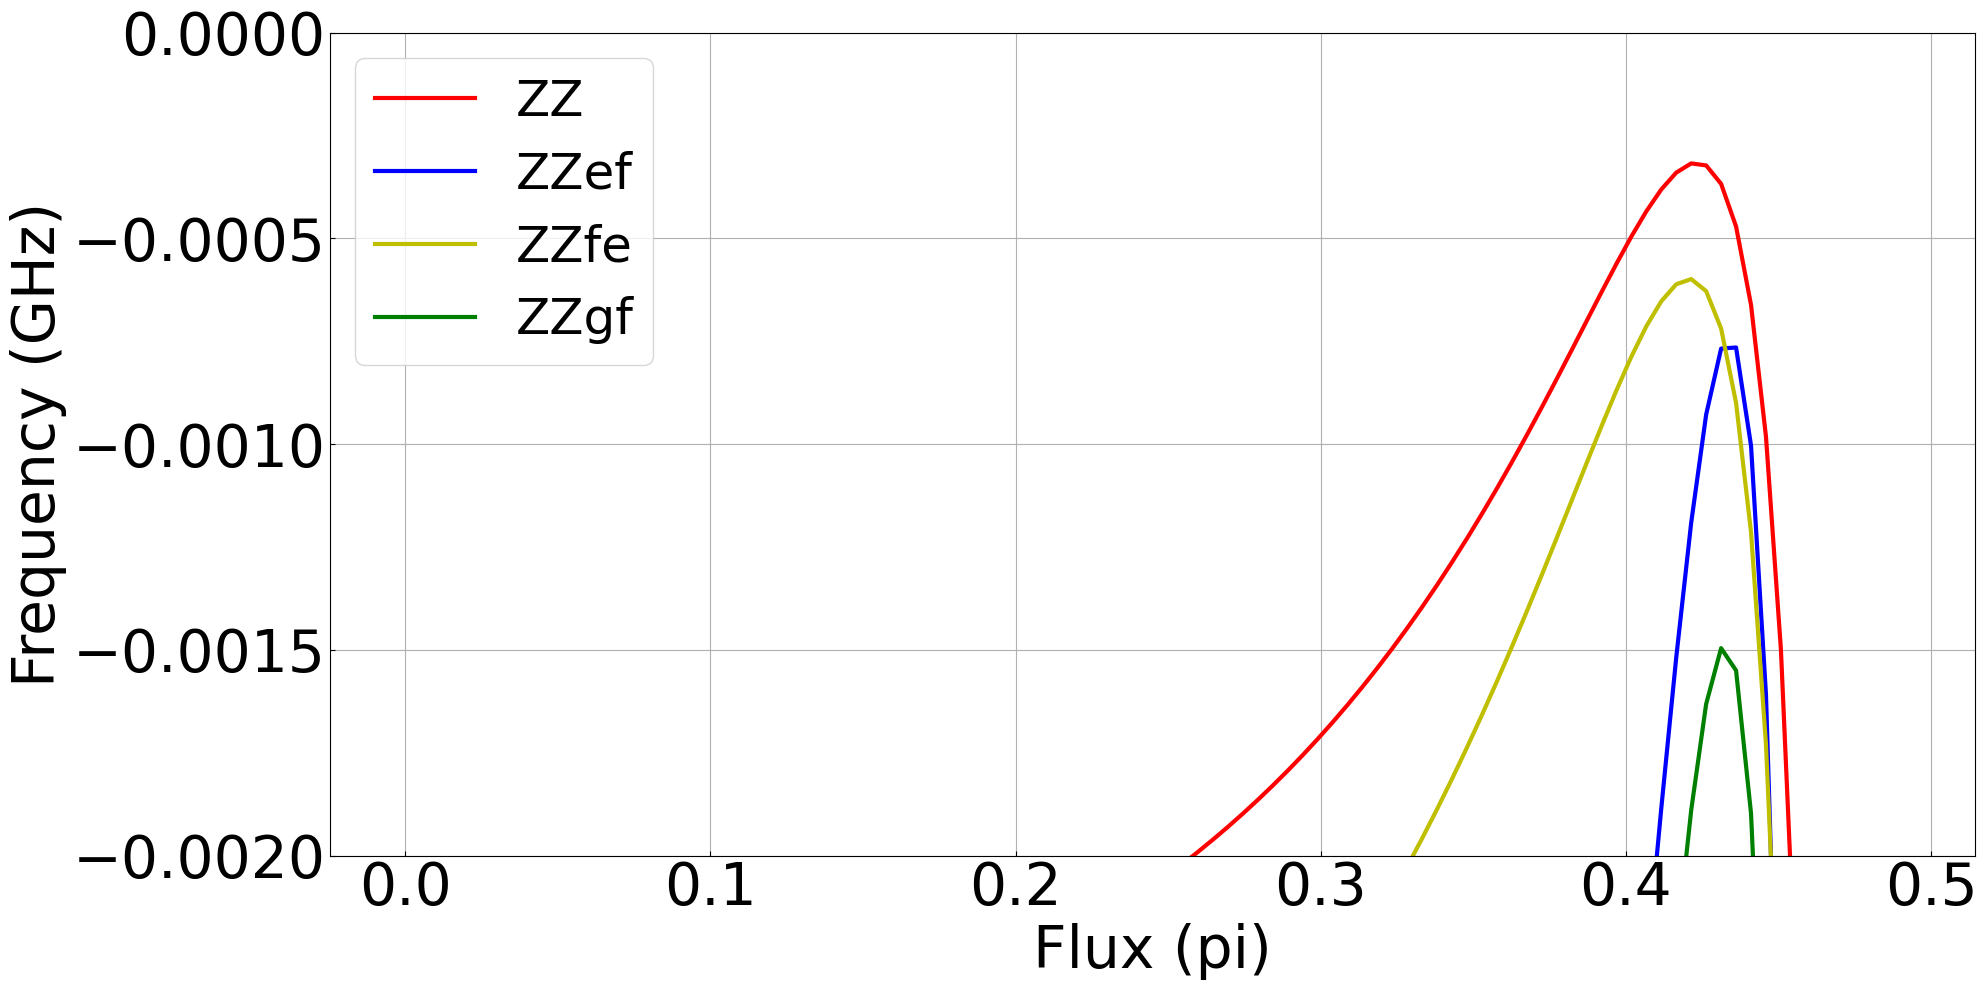

In [54]:
fig1 = plt.figure(figsize=(20,10))
plt.plot(sweep_range/pi,ZZ, color='red', linewidth=3, linestyle='-', marker='o',markersize=0.,label=r'ZZ')
plt.plot(sweep_range/pi,ZZef, color='b', linewidth=3, linestyle='-', marker='o',markersize=0.,label=r'ZZef')
plt.plot(sweep_range/pi,ZZfe, color='y', linewidth=3, linestyle='-', marker='o',markersize=0.,label=r'ZZfe')
plt.plot(sweep_range/pi,ZZgf, color='g', linewidth=3, linestyle='-', marker='o',markersize=0.,label=r'ZZgf')
# plt.plot(sweep_range/pi,ZZ1g, color='blue', linewidth=3, linestyle='-', marker='o',markersize=0.,label=r'ZZ 1-g')
# plt.plot(sweep_range/pi,ZZ2g, color='yellow', linewidth=3, linestyle='-', marker='o',markersize=0.,label=r'ZZ 2-g')

plt.tick_params(labelsize=42)
plt.rcParams['xtick.direction'] = 'in'  
plt.rcParams['ytick.direction'] = 'in'
# plt.title('3.0Cj', fontsize=36)
plt.xlabel('Flux (pi)', fontsize=42)
plt.ylabel('Frequency (GHz)', fontsize=42)
plt.ylim(-0.002, 0)
plt.legend(fontsize=36)
plt.grid()
plt.tight_layout()
plt.show()